**1. Введение и подготовка данных**

In [ ]:
import pandas as pd
df = pd.read_csv('C:/Users/AI-pc/Documents/demikello/DL/Reddit Conversations/casual_data_windows.csv', index_col = 0)

In [ ]:
df

,0,1,2
0,What kind of phone(s) do you guys have?,I have a pixel. It's pretty great. Much better...,Does it really charge all the way in 15 min?
1,I have a pixel. It's pretty great. Much better...,Does it really charge all the way in 15 min?,"Pretty fast. I've never timed it, but it's und..."
2,Does it really charge all the way in 15 min?,"Pretty fast. I've never timed it, but it's und...","cool. I've been thinking of getting one, my ph..."
3,What kind of phone(s) do you guys have?,Samsung Galaxy J1. It's my first cell phone an...,What do you think of it? Anything you don't like?
4,Samsung Galaxy J1. It's my first cell phone an...,What do you think of it? Anything you don't like?,I love it. I can't think of anything I don't l...
...,...,...,...
56292,I just won a $570 PlayStation 4 Pro at Timezone!,Are you from Singapore?Because I recognised th...,It's also in the Philippines! But our prizes a...
56293,Are you from Singapore?Because I recognised th...,It's also in the Philippines! But our prizes a...,Also in Australia!
56294,It's also in the Philippines! But our prizes a...,Also in Australia!,and New Zealand!
56295,Also in Australia!,and New Zealand!,And my axe!


In [ ]:
df = df.fillna('')

In [ ]:
catalog = list()
for line in range(len(df)):
  for col in range(3):
    catalog.append(df.loc[line][col])

C:\Users\AI-pc\AppData\Local\Temp\ipykernel_95880\3427020607.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  catalog.append(df.loc[line][col])


In [ ]:
len(catalog)/3

56297.0

In [ ]:
catalog[0]

'What kind of phone(s) do you guys have?'

In [ ]:
%%capture
!pip install nltk

In [ ]:
%%capture
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt') # Загрузка токенизатора
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

Очистка данных и разделение их на типы Questions и Answers.

In [ ]:
def gen_data(X):
    Dataset = []
    for i in range(1, len(X)):
        Q = X[i-1]
        A = X[i]

        Q = Q.lower()
        A = A.lower()

        Q = re.sub(r'<.*?>', '', Q)
        A = re.sub(r'<.*?>', '', A)

        Q = re.sub(r'http\S+|www\S+', '', Q)
        A = re.sub(r'http\S+|www\S+', '', A)

        Q = re.sub(r'[^a-zA-Z\s]', '', Q)
        A = re.sub(r'[^a-zA-Z\s]', '', A)

        Q = word_tokenize(Q) # для разделения текста на слова
        A = word_tokenize(A)

        Q = [word for word in Q if word.lower() not in stop_words]
        A = [word for word in A if word.lower() not in stop_words]

        Q = [lemmatizer.lemmatize(word) for word in Q]
        A = [lemmatizer.lemmatize(word) for word in A]

        Dataset.append([Q, A])
    return Dataset

Dataset = gen_data(catalog)

In [ ]:
len(Dataset)

168890

In [ ]:
from sklearn.model_selection import train_test_split

# Разделение данных на тренировочный, валидационный и тестовый наборы
def split_data(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Сначала разделяем данные на тренировочный и временный набор
    train_data, temp_data = train_test_split(data, test_size=(1 - train_ratio), random_state=42)
    # Разделяем временный набор на валидационный и тестовый наборы
    val_data, test_data = train_test_split(temp_data, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)
    return train_data, val_data, test_data

# Пример использования
train_data, val_data, test_data = split_data(Dataset)

In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')  # Используем предобученную модель GPT-2

# преобразовать слова в числовые значения
train_data  = [tokenizer.encode(' '.join(text[0]) + ' ' + ' '.join(text[1]), return_tensors='pt', truncation=True) for text in train_data]
val_data = [tokenizer.encode(' '.join(text[0]) + ' ' + ' '.join(text[1]), return_tensors='pt', truncation=True) for text in val_data]
test_data = [tokenizer.encode(' '.join(text[0]) + ' ' + ' '.join(text[1]), return_tensors='pt', truncation=True) for text in test_data]

C:\Users\AI-pc\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**2. Изучение архитектуры трансформера**

Основные компоненты трансформера:
 - Self-Attention: Этот механизм позволяет модели оценивать важность каждого слова в контексте других слов в последовательности. Он вычисляет взвешенные представления слов, основываясь на их взаимосвязях. Каждый элемент последовательности генерирует запросы, ключи и значения, что позволяет модели динамически определять, на какие элементы следует обращать внимание.
 - Multi-Head Attention: Этот компонент расширяет механизм самовнимания, позволяя модели одновременно учитывать различные аспекты информации. Он разделяет входные данные на несколько "голов", каждая из которых выполняет собственное внимание, а затем объединяет результаты. Это позволяет модели захватывать более сложные зависимости в данных.
 - Feed-Forward Network: После блока внимания каждый элемент последовательности проходит через полносвязную нейронную сеть, которая применяет нелинейные преобразования. Эта сеть обычно состоит из двух линейных слоев с активацией ReLU между ними, что позволяет модели обрабатывать информацию более гибко.

Позиционное кодирование: Поскольку трансформеры не имеют встроенной информации о порядке элементов в последовательности, позиционное кодирование добавляется к входным данным. Оно использует синусоидальные функции для представления позиций, что позволяет модели учитывать относительное положение слов.

Остаточные связи: Остаточные связи добавляют выход блока внимания к его входу, что помогает избежать проблемы исчезающего градиента в глубоких сетях. Это также позволяет модели сохранять информацию о первоначальных входных данных, что важно для правильной интерпретации.

Ключевые преимущества трансформера по сравнению с RNN и LSTM:
 - Параллелизация: Трансформеры могут обрабатывать все элементы последовательности одновременно, в отличие от RNN и LSTM, которые обрабатывают данные последовательно. Это значительно ускоряет обучение и вывод.
 - Долгосрочные зависимости: Трансформеры лучше справляются с долгосрочными зависимостями благодаря механизму внимания, который позволяет каждому элементу взаимодействовать с любым другим элементом в последовательности.
 - Устойчивость к шуму: Механизм внимания позволяет трансформерам игнорировать нерелевантные данные, что делает их более устойчивыми к шуму в входных данных по сравнению с RNN и LSTM.

**3. Создание модели на основе трансформера**

In [ ]:
from transformers import GPT2LMHeadModel
import torch
print(torch.__version__) # cuda 12.7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Инициализация предобученной модели
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)

2.5.1


In [ ]:
from transformers import AdamW

# Настройка гиперпараметров
batch_size = 8
num_epochs = 1
learning_rate = 5e-5

# Инициализация оптимизатора
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

C:\Users\AI-pc\anaconda3\envs\torchenv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# Дополнение последовательностей до максимальной длины в пакете
# принимает список из последовательностей (тензоров) переменной длины и дополняет их конкретным значением (обычно нулями)
# для создания партии с последовательностями одинаковой длины.
train_data = [tensor.squeeze(0) for tensor in train_data]
train_data_padded = torch.nn.utils.rnn.pad_sequence(train_data, batch_first=True)

val_data = [tensor.squeeze(0) for tensor in val_data]
val_data_padded = torch.nn.utils.rnn.pad_sequence(val_data, batch_first=True)

test_data = [tensor.squeeze(0) for tensor in test_data]
test_data_padded = torch.nn.utils.rnn.pad_sequence(test_data, batch_first=True)

# Создание TensorDatasets
train_dataset = TensorDataset(train_data_padded)
val_dataset = TensorDataset(val_data_padded)
test_dataset = TensorDataset(test_data_padded)

# Создание DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, prefetch_factor=2)

**4. Обучение модели**

In [ ]:
%%capture
!pip install nltk rouge-score

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import time
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

In [ ]:
def compute_bleu(reference, hypothesis):
    smoothing = SmoothingFunction().method1
    return sentence_bleu([reference], hypothesis, smoothing_function=smoothing)

def compute_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(' '.join(reference), ' '.join(hypothesis))
    return {key: round(value.fmeasure, 5) for key, value in scores.items()}

def train_model(model, optimizer, scheduler, num_epochs, train_loader, val_loader, device):
    train_losses = []
    val_losses = []
    val_perplexities = []
    bleu_scores = []
    rouge_scores = []

    model.to(device)

    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            inputs = batch[0].to(device)
            model.zero_grad()

            outputs = model(inputs, labels=inputs)
            loss = outputs.loss
            loss.backward()

            optimizer.step()

            if scheduler and not isinstance(scheduler, ReduceLROnPlateau): # Для других типов шедулеров, которые обновляются каждый шаг
                scheduler.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Оценка на валидационном наборе
        model.eval()
        total_val_loss = 0
        total_bleu = 0
        total_rouge = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
        n_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                outputs = model(inputs, labels=inputs)

                # Рассчитываем потери
                loss = outputs.loss
                total_val_loss += loss.item()

                # Получаем предсказания и референсы
                predicted_ids = outputs.logits.argmax(dim=-1).cpu()
                references = inputs.cpu()

                for ref, pred in zip(references, predicted_ids):
                    # Преобразуем индексы токенов обратно в текст
                    ref_tokens = tokenizer.decode(ref, skip_special_tokens=True).split()
                    pred_tokens = tokenizer.decode(pred, skip_special_tokens=True).split()

                    # Считаем BLEU
                    total_bleu += compute_bleu(ref_tokens, pred_tokens)

                    # Считаем ROUGE
                    rouge = compute_rouge(ref_tokens, pred_tokens)
                    for key in total_rouge:
                        total_rouge[key] += rouge[key]

                    n_samples += 1

        avg_val_loss = total_val_loss / len(val_loader)
        avg_bleu = round(total_bleu / n_samples, 5)
        avg_rouge = {key: round(total_rouge[key] / n_samples, 5) for key in total_rouge}

        val_losses.append(avg_val_loss)
        bleu_scores.append(avg_bleu)
        rouge_scores.append(avg_rouge)

        perplexity = math.exp(avg_val_loss)
        val_perplexities.append(perplexity)

        if scheduler:
            scheduler.step(avg_val_loss)  # Для ReduceLROnPlateau

        finish = time.time()
        res = finish - start
        res_min = res / 60
        if epoch == 0:
            print(f"Эпоха {epoch+1}/{num_epochs},", 'время обучения в мин: ', round(res_min, 2))
        else:
            print(f"Эпоха {epoch+1}/{num_epochs}")
        print(f"Средняя потеря на тренировке: {round(avg_train_loss, 5)}")
        print(f"Средняя потеря на валидации: {round(avg_val_loss, 5)}")
        print(f"Perplexity на валидации: {round(perplexity, 5)}")
        print(f"Средний BLEU: {avg_bleu}")
        print(f"Средний ROUGE: {avg_rouge}")
        print("-" * 30)

    return train_losses, val_losses, val_perplexities, bleu_scores, rouge_scores

**Optimizer - Adam, без scheduler'а**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15

# Инициализация модели и оптимизатора
model_adam = GPT2LMHeadModel.from_pretrained('gpt2')
optimizer = torch.optim.AdamW(model_adam.parameters(), lr=5e-5)
scheduler = None  # Без scheduler'а

# Обучение модели
train_losses_adam, val_losses_adam, ppl_adam, bleu_adam, rouge_adam = \
train_model(model_adam, optimizer, scheduler, num_epochs, train_loader, val_loader, device)

Эпоха 1/15, время обучения в мин:  8.58
Средняя потеря на тренировке: 1.03871
Средняя потеря на валидации: 0.94386
Perplexity на валидации: 2.56988
Средний BLEU: 0.02991
Средний ROUGE: {'rouge1': 0.19852, 'rouge2': 0.04466, 'rougeL': 0.18647}
------------------------------
Эпоха 2/15
Средняя потеря на тренировке: 0.84045
Средняя потеря на валидации: 0.82066
Perplexity на валидации: 2.272
Средний BLEU: 0.04743
Средний ROUGE: {'rouge1': 0.25093, 'rouge2': 0.08292, 'rougeL': 0.23898}
------------------------------
Эпоха 3/15
Средняя потеря на тренировке: 0.70078
Средняя потеря на валидации: 0.72924
Perplexity на валидации: 2.07351
Средний BLEU: 0.07018
Средний ROUGE: {'rouge1': 0.30793, 'rouge2': 0.12735, 'rougeL': 0.29497}
------------------------------
Эпоха 4/15
Средняя потеря на тренировке: 0.59173
Средняя потеря на валидации: 0.66157
Perplexity на валидации: 1.93783
Средний BLEU: 0.09039
Средний ROUGE: {'rouge1': 0.35383, 'rouge2': 0.17067, 'rougeL': 0.34155}
------------------------

**Optimizer - Adam, с scheduler'ом linear**

In [ ]:
# Инициализация модели и оптимизатора
model_adam_sched = GPT2LMHeadModel.from_pretrained('gpt2')
optimizer = torch.optim.AdamW(model_adam_sched.parameters(), lr=5e-5)

# Инициализация scheduler'а
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

# Обучение модели
train_losses_adam_sched, val_losses_adam_sched, ppl_adam_sched, bleu_adam_sched, rouge_adam_sched = \
train_model(model_adam_sched, optimizer, scheduler, num_epochs, train_loader, val_loader, device)

Эпоха 1/15, время обучения в мин:  8.42
Средняя потеря на тренировке: 1.04393
Средняя потеря на валидации: 0.94775
Perplexity на валидации: 2.5799
Средний BLEU: 0.02892
Средний ROUGE: {'rouge1': 0.2005, 'rouge2': 0.04334, 'rougeL': 0.18877}
------------------------------
Эпоха 2/15
Средняя потеря на тренировке: 0.8478
Средняя потеря на валидации: 0.8304
Perplexity на валидации: 2.29424
Средний BLEU: 0.04684
Средний ROUGE: {'rouge1': 0.25023, 'rouge2': 0.08101, 'rougeL': 0.23735}
------------------------------
Эпоха 3/15
Средняя потеря на тренировке: 0.71399
Средняя потеря на валидации: 0.74505
Perplexity на валидации: 2.10654
Средний BLEU: 0.06746
Средний ROUGE: {'rouge1': 0.302, 'rouge2': 0.12166, 'rougeL': 0.28873}
------------------------------
Эпоха 4/15
Средняя потеря на тренировке: 0.61224
Средняя потеря на валидации: 0.68148
Perplexity на валидации: 1.97681
Средний BLEU: 0.08466
Средний ROUGE: {'rouge1': 0.344, 'rouge2': 0.15734, 'rougeL': 0.3318}
------------------------------


**Optimizer - SGD, без scheduler'а**

In [ ]:
# Инициализация модели и оптимизатора
model_sgd = GPT2LMHeadModel.from_pretrained('gpt2')
optimizer = optim.SGD(model_sgd.parameters(), lr=1e-3)
scheduler = None  # Без scheduler'а

# Обучение модели
train_losses_sgd, val_losses_sgd, ppl_sgd, bleu_sgd, rouge_sgd = \
train_model(model_sgd, optimizer, scheduler, num_epochs, train_loader, val_loader, device)

Эпоха 1/15, время обучения в мин:  5.6
Средняя потеря на тренировке: 1.22935
Средняя потеря на валидации: 1.2234
Perplexity на валидации: 3.39871
Средний BLEU: 0.00926
Средний ROUGE: {'rouge1': 0.11752, 'rouge2': 0.00845, 'rougeL': 0.11013}
------------------------------
Эпоха 2/15
Средняя потеря на тренировке: 1.19213
Средняя потеря на валидации: 1.20534
Perplexity на валидации: 3.33789
Средний BLEU: 0.00923
Средний ROUGE: {'rouge1': 0.12119, 'rouge2': 0.00851, 'rougeL': 0.11355}
------------------------------
Эпоха 3/15
Средняя потеря на тренировке: 1.1789
Средняя потеря на валидации: 1.19521
Perplexity на валидации: 3.30424
Средний BLEU: 0.00721
Средний ROUGE: {'rouge1': 0.10984, 'rouge2': 0.00662, 'rougeL': 0.10346}
------------------------------
Эпоха 4/15
Средняя потеря на тренировке: 1.16983
Средняя потеря на валидации: 1.18658
Perplexity на валидации: 3.27585
Средний BLEU: 0.0071
Средний ROUGE: {'rouge1': 0.11254, 'rouge2': 0.00732, 'rougeL': 0.10602}
--------------------------

**Optimizer - RMSProp, без scheduler'а**

In [ ]:
# Инициализация модели и оптимизатора
model_rmsprop = GPT2LMHeadModel.from_pretrained('gpt2')
optimizer = optim.RMSprop(model_rmsprop.parameters(), lr=1e-4)
scheduler = None  # Без scheduler'а

# Обучение модели
train_losses_rmsprop, val_losses_rmsprop, ppl_rmsprop, bleu_rmsprop, rouge_rmsprop = \
train_model(model_rmsprop, optimizer, scheduler, num_epochs, train_loader, val_loader, device)

Эпоха 1/15, время обучения в мин:  7.18
Средняя потеря на тренировке: 1.04093
Средняя потеря на валидации: 0.94576
Perplexity на валидации: 2.57478
Средний BLEU: 0.03814
Средний ROUGE: {'rouge1': 0.2154, 'rouge2': 0.05689, 'rougeL': 0.20262}
------------------------------
Эпоха 2/15
Средняя потеря на тренировке: 0.83834
Средняя потеря на валидации: 0.82623
Perplexity на валидации: 2.2847
Средний BLEU: 0.05756
Средний ROUGE: {'rouge1': 0.26736, 'rouge2': 0.10093, 'rougeL': 0.25575}
------------------------------
Эпоха 3/15
Средняя потеря на тренировке: 0.70953
Средняя потеря на валидации: 0.75345
Perplexity на валидации: 2.12432
Средний BLEU: 0.07872
Средний ROUGE: {'rouge1': 0.31758, 'rouge2': 0.14748, 'rougeL': 0.30735}
------------------------------
Эпоха 4/15
Средняя потеря на тренировке: 0.6305
Средняя потеря на валидации: 0.71954
Perplexity на валидации: 2.05348
Средний BLEU: 0.09992
Средний ROUGE: {'rouge1': 0.34803, 'rouge2': 0.18141, 'rougeL': 0.33791}
-------------------------

**5. Оценка модели**

In [ ]:
# Построение графиков потерь
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, ppl_adam, label='Adam')
plt.plot(epochs, ppl_adam_sched, label='Adam + Scheduler')
plt.plot(epochs, ppl_sgd, label='SGD')
plt.plot(epochs, ppl_rmsprop, label='RMSProp')
plt.xlabel('Эпоха')
plt.ylabel('Perplexity на валидации')
plt.title('Сравнение Perplexity при разных оптимизаторах')
plt.legend()
plt.show()

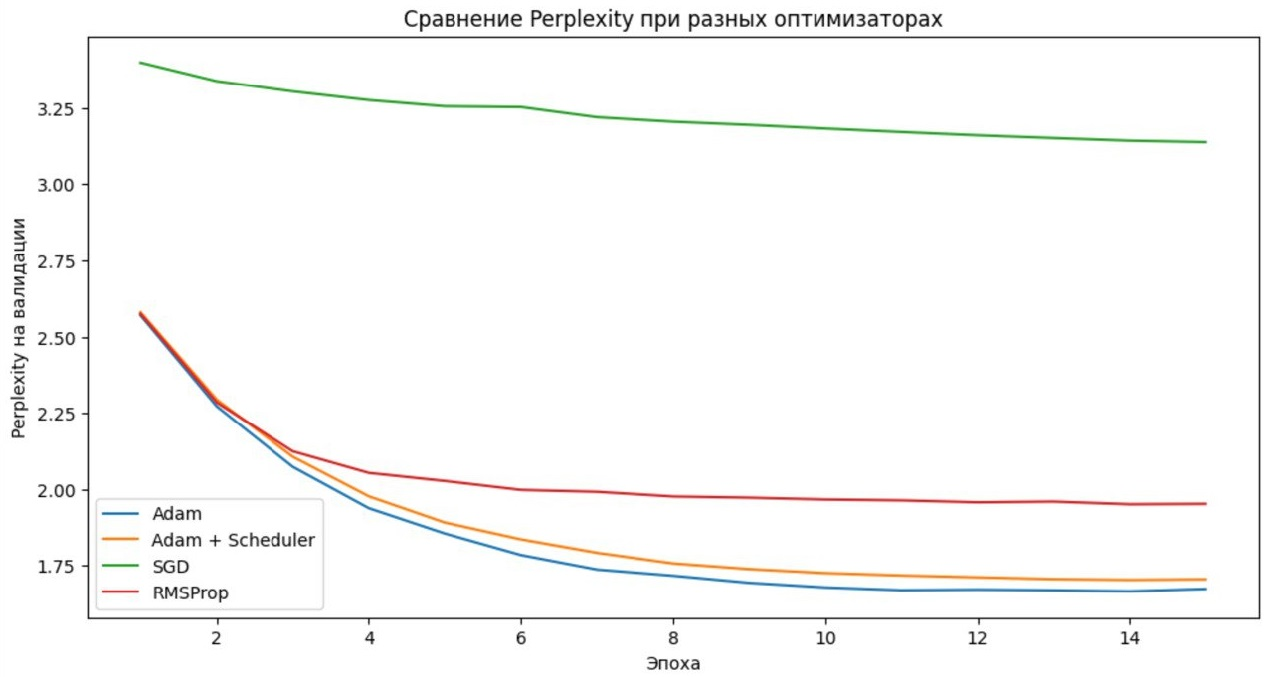

По значению перплексити видим, что модель достаточно уверенно генерирует текст и с каждой эпохой значение снижается, что видно по графикам. Наилучшим оптимизатором оказался Adam без Scheduler.

**6. Интерактивное тестирование модели**

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Загрузка модели и токенизатора
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

print("Добро пожаловать в чат! Введите ваш запрос или 'exit' для выхода.")

# Основной цикл чата
while True:
    try:
        input_text = input("Введите ваш запрос: ")

        # Завершение работы
        if input_text.lower() in ["exit", "quit"]:
            print("Чат завершен. До свидания!")
            break

        # Токенизация и генерация ответа
        inputs = tokenizer.encode(input_text, return_tensors='pt')
        outputs = model.generate(
            inputs,
            max_length=50,
            do_sample=True,
            top_k=50,       # Учитываются 50 наиболее вероятных токенов
            top_p=0.95      # Выбор слов с общей вероятностью не более 0.95
        )

        # Декодирование и вывод ответа
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print("Ответ бота:", response)

    except Exception as e:
        print("Произошла ошибка:", str(e))
        print("Попробуйте еще раз.")

Добро пожаловать в чат! Введите ваш запрос или 'exit' для выхода.


Введите ваш запрос:  What kind of phone(s) do you guys have?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Ответ бота: What kind of phone(s) do you guys have? I'd have to talk to you."

So I got to talking to G.G. before we flew to Las Vegas. He said he's not sure who the guy was but


В целом, модель смогла выдать какой то связный ответ, однако осмысленность данного ответа остается под вопросом.